### Loading and getting a sense of the data

First of all, let's load the necessary libraries for importing the data and processing the text.

In [1]:
import csv
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


Let's load the dataset and take a look at some of the different articles and their preclassified category.

In [2]:
articles = pd.read_csv('bbc-text.csv')
articles.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


Now it would be a good idea to check the number of articles in each category. This way we can look for class imbalance that may affect our model. In case you cannot or do not want to install cufflings and plotly a static picture is also attached below.

In [3]:
'''Run the code below if you want to have the interactive plots. 
Keep in mind that you have to install the libraries at your command line/terminal using:

    pip install plotly
    pip install cufflinks

** NOTE: Make sure you only have one installation of Python on your computer when you do this, otherwise the 
installation may not work. **'''

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf

print(__version__) # requires version >= 1.9.0
init_notebook_mode(connected=True)
cf.go_offline()

articles['category'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Articles', title='Number of articles in each category')

4.5.4


<img src="Screenshots/no_of_categories.png" width='940' height='300'/>

There is some imbalance between the classes but it is not significant.

### Text preprocessing

As to all projects in data science, a critical part of analysis is preprocessing. In text analysis, our goal is to create a corpus which will be consisted of different words that will make up our vocabulary. We need to make that vocabulary as small as possible but at the same time, keep all of the essential information and "key" words for labelling. As a result, we will remove a category of words called "stopwords", which are words commonly used in our vocabulary but do not add any value to our model when it comes to classifying the text to a specific category. Let's see which these words are.

In [4]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
print(STOPWORDS)

{"she's", 'once', 'only', 'their', 'other', 'mightn', 'into', 'before', "aren't", 'out', 'can', "don't", 'while', 'his', 'at', 'further', 'nor', 'y', 'this', 'after', 'she', 'herself', 'be', 'between', 'under', "wouldn't", 'been', 'during', 'who', "weren't", 'wouldn', 'that', 'her', "you'll", "hadn't", "shan't", 'had', 'and', 'when', 'has', 'in', 'too', "shouldn't", 'i', 'by', 'mustn', 'which', 'not', 'hadn', 'because', 'am', 'with', 'as', 'any', 'was', 'haven', 't', 'ourselves', 'the', 'm', 'so', 'our', 'some', "you're", "haven't", 'its', 'here', 'you', 'down', 'him', 'what', 'hasn', 'few', 'does', 'doing', "didn't", 'won', 'up', "mustn't", 'but', 'wasn', 'such', 'couldn', 'weren', 'theirs', "doesn't", 'itself', 'each', 'a', 'below', 'about', 'where', 'through', 'ours', 'how', 'doesn', 'those', 'all', 'above', 'than', 've', 'll', 'very', 'now', 'me', 'do', 'off', "isn't", 'against', "you've", 're', "that'll", 'myself', 'himself', 'most', 'on', "won't", 'didn', 'them', 'needn', 'if', '

Now it's time to separate each article's text from its corresponding label. For our analysis, the text is the "independent variable" and the label is the target or "dependent variable". Thus, we will train our model to read a text and predict whether it falls under the sport, business, politics, tech, or entertainment category.

During this separation we will also proceed with cleaning the dataset by removing the stopwords we mentioned above.

In [5]:
text = []
categories = []

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        categories.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace('  ', ' ')
        text.append(article)

To get a good grasp of what exactly we have achieved, let's print one of the articles before and after the removal of stopwords. That way we can see the actual value this removal brings.

In [6]:
def print_plot(index):
    example = articles[articles.index == index][['text', 'category']].values[0]
    if len(example) > 0:
        print('Product:', example[1])
        print('\n')
        print(example[0])
        
def comparison(i):
    print_plot(i)
    print('Length: ',len(articles.iloc[i][1]))
    print(115*'=')
    print(text[i]) 
    print('Length: ',len(text[i]))

comparison(4)

Product: entertainment


ocean s twelve raids box office ocean s twelve  the crime caper sequel starring george clooney  brad pitt and julia roberts  has gone straight to number one in the us box office chart.  it took $40.8m (£21m) in weekend ticket sales  according to studio estimates. the sequel follows the master criminals as they try to pull off three major heists across europe. it knocked last week s number one  national treasure  into third place. wesley snipes  blade: trinity was in second  taking $16.1m (£8.4m). rounding out the top five was animated fable the polar express  starring tom hanks  and festive comedy christmas with the kranks.  ocean s twelve box office triumph marks the fourth-biggest opening for a december release in the us  after the three films in the lord of the rings trilogy. the sequel narrowly beat its 2001 predecessor  ocean s eleven which took $38.1m (£19.8m) on its opening weekend and $184m (£95.8m) in total. a remake of the 1960s film  starring frank s

Reading both texts we can easily understand what each one is trying to describe, but on the second text we have kept only the "key" words. Mind the difference at the length of the article. Now we have a more condense but equally informative form. It is obvious though that there are a lot of things that we can ommit like punctuation and special characters. We will take care of this shortly.

At this point, it would be a good idea to set the hyperparameters we will use throughout our code to make it easier to change and edit in the future if needed, since each one of them is totally tunable. We will explain how each hyperparameter works when we get there.

In [7]:
# --Hyperparameters--

vocab_size = 5000
embedding_dim = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<UW>'
labels=sorted(set(categories))
print('Labels: ',labels)


Labels:  ['business', 'entertainment', 'politics', 'sport', 'tech']


The next step is to encode our labels. Right now, our target values are words. Since we are feeding this data to a deep learning model, each category needs to be an array where all of the categories -except the one corresponding to the specific article- will be zero. This can be easily done through keras.

In [8]:
# -- Encoding the labels -- 

from sklearn.preprocessing import LabelEncoder
labelencoder_categories = LabelEncoder()
categories = labelencoder_categories.fit_transform(categories)
categories = keras.utils.to_categorical(categories, num_classes=5, dtype='int')

To understand exactly the transformation from words to arrays of zeros and ones we can see the picture below:

<img src="Screenshots/label_encoding.png" width='600' height='300'/>

Now it's time to split our dataset into a training set and a test set. There are 2,225 news articles in the data, we split them into training set and test set, 80% for training, 20% for validation.

In [9]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
train_text, test_text, train_labels, test_labels = train_test_split(text, categories, train_size = 0.8, random_state = 0)

print("Number of articles in training set: " + str(len(train_text)))
print("Number of labels in training set: " + str(len(train_labels)))
print("Number of articles in test set: " + str(len(test_text)))
print("Number of labels in test set: " + str(len(test_labels)))

Number of articles in training set: 1780
Number of labels in training set: 1780
Number of articles in test set: 445
Number of labels in test set: 445


The next step, is one of the most essential steps in the process and it involves the [tokenization](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) of our text. For this purpose, we will use the Tokenizer class from keras. This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on different methods. It is also cleaning our text further more.

In [10]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                      lower=True)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index
print('Number of Unique Tokens: ',len(word_index))

Number of Unique Tokens:  27233


Let's explain a little bit further all of the arguments we used for the Tokenizer:

* num_words: the maximum number of words to keep, based on word frequency. This is basically our vocabulary which will be equal to 5000 words.
* filters: a string where each element is a character that will be
    filtered from the texts. We used the *default*, which is all punctuation, plus
    tabs and line breaks, minus the `'` character.
* lower: boolean. Whether to convert the texts to lowercase. We set this to True.
* oov_token: puts a special value in when an unseen word is encountered. This means we want `<UW>` ('Unknown Word') to be used for words that are not in our vocabulary and hence not in the `word_index. fit_on_text`. 

The next steps are part of preparing our data for our neural networks. Firstly, we have to turn those tokens into lists of sequence. Secondly, we need to bring those sequences to the same length. To achieve that, we will use a technique called "padding", a practice which includes adding data to the beginning or end of our texts in order to bring them to the same size. 

In [11]:
# Turning tokens into lists of sequence
train_text_sequences = tokenizer.texts_to_sequences(train_text)

# Setting as max_length the mean length of the cleaned articles
max_length = int(sum([len(train_text_sequences[i]) for i in range(len(train_text_sequences))])/len(train_text_sequences))
print(f"Mean length of articles: {max_length}")

# Use padding to bring sequences into the same size in order to feed them to NLP neural network
train_text_padded = pad_sequences(train_text_sequences, maxlen = max_length, padding = padding_type, 
                                  truncating = trunc_type)


Mean length of articles: 230


Again, let's see the arguments used for our padding in a little bit more detail:

* maxlen: the maximum length of all sequences. We have set this as the mean length of our articles, after they have been cleaned up by removing stopwords, double spaces, punctuation and special characters.
* padding: 'pre' or 'post' (optional, defaults to 'pre'). Pad either before or after each sequence. We have set it to `'post'` when we were creating our hyperparameters.
* truncating: 'pre' or 'post' (optional, defaults to 'pre'). Remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences. We have set it to `'post'` when we were creating our hyperparameters.

As a result, all our articles are now tokenized sequences with length equal to 230 and we achieved that either by deleting all the numbers after the 230th for sequences with length greater than 230, or by adding complementary 0's at the end of the sequence until it reaches a length of 230. 

Now we repeat the exact same process,  this time for the test sequences. Note that we should expect more "out of vocabulary" words from articles in the test split because word indexes were derived from the training articles. That is because we fit Tokenizer to training set only, mimicking the fact that unseen words will appear at some point after deploying our model. Thus, model evaluation will be closer to what will happen in an actual production environment.

We will also turn the category labels into numpy arrays because that is the form expected from our neural network.

In [12]:
# Turning tokens into lists of sequence
test_text_sequences = tokenizer.texts_to_sequences(test_text)

# Use padding to bring sequences into the same size in order to feed them to NLP neural network
test_text_padded = pad_sequences(test_text_sequences, maxlen=max_length, padding=padding_type, 
                                 truncating=trunc_type)

# Turn the categories into numpy arrays
train_labels_sequences = np.asarray(train_labels)
test_labels_sequences = np.asarray(test_labels)

We are finally done with all the necessary preprocessing. Before we move on to creating our document classifiers, it would be fun to see how all of these actions affected our articles through an example. Let's compare one article before and after tokenizing, cleaning and padding. Note that in the first article we have already removed stopwords.

In [13]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print("Original text:",'\n')
print(train_text[10])
print('Length: ',len(train_text[10]))
print(115*'=')
print("Transformed text:",'\n')
print(decode_article(train_text_padded[10]))
print('Length: ',len(train_text_padded[10]))

Original text: 

chelsea denied james heroics brave defensive display led keeper david james helped manchester city hold leaders chelsea. quiet opening james denied damien duff jiri jarosik mateja kezman paul bosvelt cleared william gallas header line. robbie fowler scored visitors sent header wide. chelsea possession second half james kept frank lampard free-kick superbly tipped player volley wide. city went game proud record domestic team beat chelsea season. little alarm first 30 minutes chelsea - deprived arjen robben didier drogba injury - struggled pose much threat. indeed visitors looked likelier enliven drab opening played lethargic pace. shaun wright-phillips - watched england boss sven-goran eriksson - showed customary trickery burst right area deliver dangerous ball blocked john terry. chelsea suddenly stepped gear created flurry chances. first duff got round ben thatcher blasted shot james parried kezman turned ball wide. soon afterwards jarosik found space area powerfully 

In this particular example, we managed to create a transformed text which is 10 times smaller(!!!) than the original article. But what is really remarkable, is the fact that reading the transformed text we can still understand what it is trying to describe. Hence, we can proudly brag that we achieved our goal: minimize the size of our texts but keeping all of the essential information.

### Word embeddings - GloVe

Before we proceed with building our neural network we should talk about [word embeddings](https://en.wikipedia.org/wiki/Word_embedding). Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation. This technique works well with deep learning methods. The distributed representation is learned based on the usage of words. This allows words that are used in similar ways to result in having similar representations, naturally capturing their meaning. The whole concept is based on the idea that words that have similar context will have similar meanings. 

The algorithm which we will be using for learning a word embedding from text data is called [GloVe](https://nlp.stanford.edu/projects/glove/). The Global Vectors for Word Representation, or GloVe, is an extension to the [Word2vec](https://en.wikipedia.org/wiki/Word2vec) (another word embedidng method) for efficiently learning word vectors. GloVe constructs an explicit word-context or word co-occurrence matrix using statistics across the whole text corpus. The result is a learning model that may create better word embeddings.

We can either train a new embedding or use a pre-trained embedding on our natural language processing task. Both word2vec and GloVe word embeddings are available for free [download](https://github.com/stanfordnlp/GloVe/blob/master/README.md). We will be using the `glove.6B.100d` version. 

After we download it, we have to load the entire GloVe word embedding file into memory as a dictionary of word to embedding array. Next, we need to create a matrix of one embedding for each word in the training dataset.

In [14]:
# Loading GloVe to memory as a dict
embeddings_index = {};
with open('glove.6B.100d.txt',encoding="UTF-8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs;
print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

# Creating weights matrix
embeddings_matrix = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embeddings_matrix[i] = embedding_vector       

Total 400000 word vectors in Glove 6B 100d.


### Building the models

It's finally time to build our document classifiers. As we mentioned at the [read me] file, we will create two neural networks. The first one will be based on a [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN) and the second one will be based on a [Bidirectional Recurrent Neural Network](https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks) (BRNN). In the end we will compare the results.  

For both of our classifiers, as a first layer we will use our pre-trained GloVe embedding. Thus the name "Embedding Layer". The size of the vector space is specified as part of the model, such as 50, 100, or 300 dimensions. When we defined our hyperparameters, we set our dimensions to 100. The embedding layer is used on the front end of a neural network and is fit in a supervised way using the [Backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algorithm.

#### CNN document classifier

Simplified convolutional neural network
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 230, 100)          2723400   
_________________________________________________________________
conv1d (Conv1D)              (None, 226, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 45, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 41, 128)           82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)   

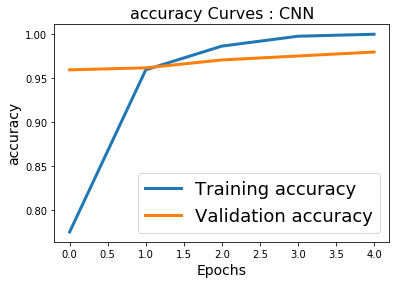

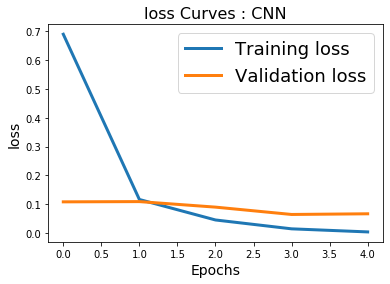

In [15]:
cnn_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(word_index)+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], 
                                  trainable=True),
        #using a total of 128 filters with size 5 and max pooling of 5 and 35
        tf.keras.layers.Conv1D(128, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(5),
        tf.keras.layers.Conv1D(128, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(35),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(labels), activation = 'softmax')
])
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Simplified convolutional neural network")
cnn_model.summary()

# Run this to train the classifier to our data and visualize the results
num_epochs = 5
history_cnn = cnn_model.fit(train_text_padded, train_labels_sequences, epochs=num_epochs, 
                    validation_data=(test_text_padded, test_labels_sequences), verbose=2)

# Visualizing the results
import matplotlib.pyplot as plt
def plot_graphs(history_cnn, string):
  plt.plot(history_cnn.history[string],linewidth=3.0)
  plt.plot(history_cnn.history['val_'+string],linewidth=3.0)
  plt.xlabel("Epochs",fontsize=14)
  plt.ylabel(string,fontsize=14)
  plt.legend(['Training '+string, 'Validation '+string],fontsize=18)
  plt.title(string +' Curves : CNN',fontsize=16)
  plt.show()
  
plot_graphs(history_cnn, "accuracy")
plot_graphs(history_cnn, "loss")

#### BRNN document classifier

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 230, 100)          2723400   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 2,904,805
Trainable params: 2,904,805
Non-trainable params: 0
_________________________________________________________________
Train on 1780 samples, validate on 445 samples
Epoch 1/5
1780/1780 - 6s - loss: 0.6673 - accuracy: 0.7787 - val_loss: 0.1838 - val_accuracy: 0.9438
Epoch 2/5
1780/1780 - 3s - loss: 0.1619 - accuracy: 0.9449 - val_loss: 0.1344 - val_accuracy: 

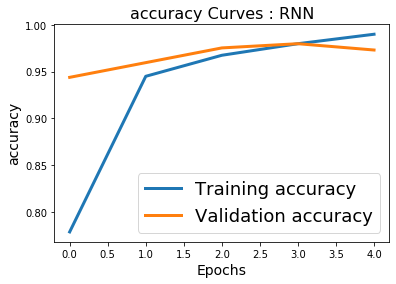

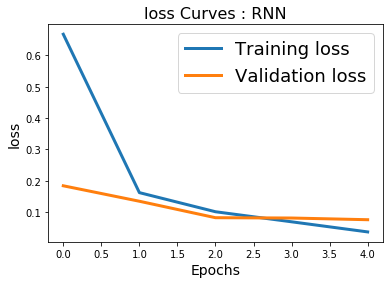

In [16]:
rnn_model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of a particular size, and output embedding dimension of size 100
    tf.keras.layers.Embedding(len(word_index)+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    # used ReLU and tanh function but relu performed better.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 5 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(5, activation='softmax')
])
rnn_model.summary()
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Run this to train the classifier to our data and visualize the results
num_epochs = 5
history_rnn = rnn_model.fit(train_text_padded, train_labels_sequences, epochs=num_epochs, 
                    validation_data=(test_text_padded, test_labels_sequences), verbose=2)

# -- Visualizing the results -- 

import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history_rnn.history[string],linewidth=3.0)
  plt.plot(history_rnn.history['val_'+string],linewidth=3.0)
  plt.xlabel("Epochs",fontsize=14)
  plt.ylabel(string,fontsize=14)
  plt.legend(['Training '+string, 'Validation '+string],fontsize=18)
  plt.title(string +' Curves : RNN',fontsize=16)
  plt.show()
  
plot_graphs(history_rnn, "accuracy")
plot_graphs(history_rnn, "loss")

### Comparing the results

It looks like the bidirectional recurrent neural network did a better job approximating our training set results, while the convolutional neural network does show some signs of overfitting. We have to note that I had to bring down the original complexity of my CNN architecture since Jupyter notebook did not have the computational capacity to handle the extra layers. The purpose of this project was to provide a roadmap to anyone who wants to build his/her own document classifier, but there are definitely more steps that we could do take to improve our model. Some of them would be:
* Use more data. In our dataset we have only 2,225 articles, a number which is considered small.
* Fine tune our hyperparameters. Fine tuning can be performed by Manual Search, Grid Search, Random Search etc.
* Improve text pre-processing. 
* Introduce dropout layer(s) in our models. That would help in avoid overfitting and increasing the generalizing power.

### Thank you!